In [557]:
import pandas as pd
import datetime as dt
import numpy as np
import glob
import re

holidays = [dt.date(2020,12,31),dt.date(2021,1,1),dt.date(2021,1,2), dt.date(2021,1,3), dt.date(2021,1,4), dt.date(2021,1,5), 
            dt.date(2021,1,6), dt.date(2021,1,7), dt.date(2021,1,8), dt.date(2021,1,9), dt.date(2021,1,10), dt.date(2021,2,22),
            dt.date(2021,2,23), dt.date(2021,3,8), dt.date(2021,5,3),dt.date(2021,5,4), dt.date(2021,5,5), dt.date(2021,5,6), 
            dt.date(2021,5,7), dt.date(2021,5,10), dt.date(2021,11,4), dt.date(2021,11,5)]
   

def preprocess_dataframe(dataframe):
    dataframe['Время звонка']=dataframe['Время звонка'].astype('str')
    dataframe['Время ожидания']=pd.to_timedelta(dataframe['Время ожидания'].astype('str'))
    dataframe['Время разговора']=pd.to_timedelta(dataframe['Время разговора'].astype('str'))
    
    dataframe=dataframe.groupby((dataframe[['Номер телефона']].isnull()==False).all(1).cumsum()).agg({'Время звонка': ' '.join, 'Номер телефона': 'first', 'Статус звонка': 'first',
                  'Время ожидания': 'first', 'Время разговора': 'first',
                  'Группа': 'first', 'Оператор': 'first'})
    
    dataframe['Время звонка']=dataframe['Время звонка'].apply(lambda x: dt.datetime.strptime(x, '%H:%M:%S %Y-%m-%d 00:00:00'))
    dataframe['Дата звонка']=dataframe['Время звонка'].dt.date
    dataframe['День недели']=dataframe['Время звонка'].apply(lambda x: x.weekday())
    dataframe['Час звонка']=dataframe['Время звонка'].dt.hour
    dataframe['Время звонка']=dataframe['Время звонка'].dt.time
    
    dataframe['Время ожидания']=dataframe['Время ожидания'].apply(lambda x: x.total_seconds()/60)
    dataframe['Время разговора']=dataframe['Время разговора'].apply(lambda x: x.total_seconds()/60)
    
    dataframe['Оператор']= dataframe['Оператор'].replace({np.nan:None})
    dataframe['Отчетная дата'] = dataframe['Дата звонка'] + dt.timedelta(days=1) 
    return dataframe


def table_waiting_time(total):
    total['Ждали']=total['Время ожидания'].apply(lambda x: x*60)
    total['Ждали']= total.apply(lambda row: row['Ждали'], axis=1)
    total['Время ожидания звонка']=total['Ждали'].apply(lambda x: dt.time(int(x/3600), int((x-int(x/3600)*3600)/60), int(x-int(x/60)*60)))
    #table = total_all_days.sort_values(by='Время ожидания', ascending=False)[['Дата звонка','Время звонка','Время ожидания звонка', 'Группа', 'Оператор', 'Статус звонка']].copy()
    table = total.sort_values(by='Время ожидания', ascending=False).loc[:,('Дата звонка','Время звонка','Время ожидания звонка', 'Группа', 'Оператор', 'Статус звонка')]
    print(table)
    return table

def table_waiting_time2(total_all_days):
    total_all_days['Ждали']=total_all_days['Время ожидания'].apply(lambda x: x*60)
    total_all_days['Ждали']= total_all_days.apply(lambda row: row['Ждали'], axis=1)
    total_all_days['Время ожидания звонка']=total_all_days['Ждали'].apply(lambda x: dt.time(int(x/3600), int((x-int(x/3600)*3600)/60), int(x-int(x/60)*60)))
    #table = total_all_days.sort_values(by='Время ожидания', ascending=False)[['Дата звонка','Время звонка','Время ожидания звонка', 'Группа', 'Оператор', 'Статус звонка']].copy()
    table = total_all_days.sort_values(by='Время ожидания', ascending=False).loc[:,('Дата звонка','Время звонка','Время ожидания звонка', 'Группа', 'Оператор', 'Статус звонка')]
    return table

# -
def calculate_statistics(dataframe, title):
    reporting_date = dataframe['Дата звонка'].values[0]
    
    day = dataframe[(dataframe['Час звонка'] >=8 ) & (dataframe['Час звонка']  < 20)]
    night = dataframe[(dataframe['Час звонка'] < 8) | (dataframe['Час звонка'] >= 20)]
    oper_df=dataframe[(dataframe['Оператор'].notna()) & (dataframe['Оператор']!='--')]

    # Рассчитываем количество операторов в рабочее время (c 8:00 по 20:00)
    work_day_df = oper_df[(oper_df['Час звонка']>=8) & (oper_df['Час звонка'] < 20)]
    all_oper_day = len(work_day_df['Оператор'].unique())
    oper_day=len(work_day_df[work_day_df['Статус звонка']!='Не дождался'] ['Оператор'].unique())

    # Рассчитываем количество операторов в НЕ рабочее время
    not_work_day_df = oper_df[(oper_df['Час звонка'] < 8) | (oper_df['Час звонка'] >= 20)]
    all_oper_night = len(not_work_day_df['Оператор'].unique())
    oper_night=len(not_work_day_df[not_work_day_df['Статус звонка']!='Не дождался'] ['Оператор'].unique())
    all_oper = len(oper_df['Оператор'].unique())


    # Рассчитываем количество званков всего
    all_calls = dataframe.shape[0]
    # Рассчитываем количество званков ночью
    all_night_calls = night.shape[0]
    # Рассчитываем количество званков днём
    all_work_day_calls = day.shape[0]


    # Рассчитываем количество пропущенных всего званков
    all_missed_calls=dataframe[dataframe["Статус звонка"]=='Не дождался'].shape[0]
    # Рассчитываем количество пропущенных званков днём
    day_missed_calls = day[day["Статус звонка"]=='Не дождался'].shape[0]
    # Рассчитываем количество пропущенных званков ночью
    night_missed_calls = night[night["Статус звонка"]=='Не дождался'].shape[0]


    # Рассчитываем среднее время разговора за сутки
    mean_talk=np.round(dataframe['Время разговора'].mean(),1)
    # Рассчитываем среднее время разговора за день
    day_mean_talk=np.round(day['Время разговора'].mean(),1)
    # Рассчитываем среднее время разговора за ночь
    night_mean_talk = np.round(night['Время разговора'].mean(),1)


    # Рассчитываем максимальнок время ожидание
    max_wait_df = dataframe[dataframe['Время ожидания']==dataframe['Время ожидания'].max()]
    # За сутки
    max_wait=np.round(dataframe['Время ожидания'].max(),1)
    time_with_max_wait = max_wait_df['Время звонка'].values[0]
    # За день
    max_wait_day_df = day[day['Время ожидания']==day['Время ожидания'].max()]
    max_wait_day = np.round(day['Время ожидания'].max(),1)
    time_with_max_wait_day = max_wait_day_df['Время звонка'].values[0]
    # За ночь
    max_wait_night_df = night[night['Время ожидания'] == night['Время ожидания'].max()]
    max_wait_night = np.round(night['Время ожидания'].max(),1)    
    time_with_max_wait_night =  0 if max_wait_night_df.empty else max_wait_night_df['Время звонка'].values[0]    
    
    
    # Рассчитываем у какого оператора было максимальнок время ожидание и в какой он группе
    # За сутки
    group_with_max_wait = max_wait_df['Группа'].values[0]
    oper__with_max_wait = max_wait_df['Оператор'].values[0]
    # За день
    group_with_max_wait_day = max_wait_day_df['Группа'].values[0]
    oper__with_max_wait_day = max_wait_day_df['Оператор'].values[0]
    # За ночь
    group_with_max_wait_night = 0 if max_wait_night_df.empty else max_wait_night_df['Группа'].values[0]
    oper__with_max_wait_night = 0 if max_wait_night_df.empty else max_wait_night_df['Оператор'].values[0]
    
    
    # Рассчитываем среднее время ожидание
    all_wait = dataframe['Время ожидания']
    day_wait = day['Время ожидания']
    night_wait = night['Время ожидания']
    # За сутки
    mean_wait = np.round(all_wait.mean(),5)
    # За день
    mean_wait_day = np.round(day_wait.mean(),5)
    # За ночь
    mean_wait_night = np.round(night_wait.mean(),5)

    # Рассчитываем ожидание более 3 минут
    # За сутки
    more_3_min_df = dataframe[all_wait >= 3].shape[0]
    more_3_min = np.round(more_3_min_df * 100 / all_calls, 0)
    # За день
    more_3_min_day_df = day_wait[day_wait >= 3].shape[0]
    more_3_min_day = np.round(more_3_min_day_df * 100 / all_calls, 0)
    # За ночь
    more_3_min_night_df = night_wait[night_wait >= 3].shape[0]
    more_3_min_night = np.round(more_3_min_df * 100 / all_calls, 0)

    # За сутки
    print(f'{title}\nза {reporting_date}\n')
    print('Информация за сутки: \n')
    print(f'Число операторов всего: {all_oper},\nВсего звонков {all_calls}, неотвеченных вызовов: {all_missed_calls}')
    print(f'Среднее время разговора за сутки (мин): {mean_talk}')
    print(f'Максимальное время ожидания за сутки (мин): {max_wait} (Оператор: {oper__with_max_wait}, Группа: {group_with_max_wait}, Время звонка: {time_with_max_wait})')
    print(f'Среднее время ожидания за сутки(мин): {mean_wait}')
    print(f'Ожидание более 3 минут за сутки (%): {more_3_min}\n')

    # За день
    print('\nИнформация за рабочий день (с 8:00 до 20:00): \n')
    print(f'Число операторов днем {all_oper_day}, из них {oper_day} отвечали на звонки')
    print(f'Днем позвонили {all_work_day_calls} раз, из них неотвеченных вызовов: {day_missed_calls}')
    print(f'Среднее время разговора денём (мин): {day_mean_talk}')
    print(f'Максимальное время ожидания днём (мин): {max_wait_day} (Оператор: {oper__with_max_wait_day}, Группа: {group_with_max_wait_day}, Время звонка: {time_with_max_wait_day})')
    print(f'Среднее время ожидания днём (мин): {mean_wait_day}')
    print(f'Ожидание более 3 минут днём (%): {more_3_min_day}\n')

    # За ночь
    print('\nИнформация за ночь (с 00:00 до 8:00 и с 20:00 до 00:00): \n')
    print(f'Число операторов ночью {all_oper_night}, из них {oper_night} отвечали на звонки')
    print(f'Ночью позвонили {all_night_calls} раз, из них неотвеченных вызовов: {night_missed_calls}')      
    print(f'Среднее время разговора ночью (мин): {night_mean_talk}')
    print(f'Максимальное время ожидания ночью (мин): {max_wait_night} (Оператор: {oper__with_max_wait_night}, Группа: {group_with_max_wait_night}, Время звонка: {time_with_max_wait_night})')    
    print(f'Среднее время ожидания ночью (мин): {mean_wait_night}')
    print(f'Ожидание более 3 минут ночью (%): {more_3_min_night}')


def create_df(names):
    cont = []
    for i in range(len(names)):
        if names[i] =='../Недозвоны/ВМК1\~$2022-02-01.xlsx':
            continue
#         print(names[i])
        df = pd.read_excel(names[i], engine='openpyxl')
        df=preprocess_dataframe(df)

        cont.append(df)
    return pd.concat(cont)
    
names= glob.glob('../Недозвоны/ВМК1/*', recursive=True)
names2= glob.glob('../Недозвоны/ВМК2/*', recursive=True)
# names = glob.glob('/home/trinity/Anaconda code/Работа/Недозвоны/ВМК1/*', recursive=True)
# names2 = glob.glob('/home/trinity/Anaconda code/Работа/Недозвоны/ВМК2/*', recursive=True)
#namesRT = glob.glob('/home/trinity/Anaconda code/Работа/Недозвоны/ВМК2/*', recursive=True)

total_all_days = create_df(names)
total_all_days['Группа']=total_all_days['Группа'].replace({'Общая':'Медколледж','group':'Облкомобразования','Консультация':'Облкомобразования'})

total_all_days2 = create_df(names2)
total_all_days2['Группа']=total_all_days2['Группа'].replace({'Общая':'Медколледж','group':'Облкомобразования','Консультация':'Облкомобразования'})


# Выбор отчётной даты

In [558]:
#day=dt.date.today()
day=dt.date(2022,2,15)

# Создаём датафрейм для первого домена
df_specific_day = total_all_days[total_all_days['Дата звонка']==day].copy()
reporting_date = df_specific_day['Дата звонка'].values[0]


### Считаем статистику по первому домену

In [559]:
calculate_statistics(df_specific_day,'Данные по первому домену')

Данные по первому домену
за 2022-02-15

Информация за сутки: 

Число операторов всего: 20,
Всего звонков 2001, неотвеченных вызовов: 77
Среднее время разговора за сутки (мин): 0.9
Максимальное время ожидания за сутки (мин): 10.2 (Оператор: user80, Группа: Медколледж, Время звонка: 07:49:38)
Среднее время ожидания за сутки(мин): 0.318
Ожидание более 3 минут за сутки (%): 4.0


Информация за рабочий день (с 8:00 до 20:00): 

Число операторов днем 20, из них 20 отвечали на звонки
Днем позвонили 1770 раз, из них неотвеченных вызовов: 22
Среднее время разговора денём (мин): 0.6
Максимальное время ожидания днём (мин): 1.4 (Оператор: user109, Группа: Медколледж, Время звонка: 08:00:25)
Среднее время ожидания днём (мин): 0.08011
Ожидание более 3 минут днём (%): 0.0


Информация за ночь (с 00:00 до 8:00 и с 20:00 до 00:00): 

Число операторов ночью 16, из них 16 отвечали на звонки
Ночью позвонили 231 раз, из них неотвеченных вызовов: 55
Среднее время разговора ночью (мин): 2.9
Максимальное врем

### Таблица максимального времени ожидания за конктретную дату

In [560]:
table_waiting_time(df_specific_day).head(20)

     Дата звонка Время звонка Время ожидания звонка      Группа Оператор  \
196   2022-02-15     07:49:38              00:10:13  Медколледж   user80   
198   2022-02-15     07:49:52              00:10:13  Медколледж  user110   
194   2022-02-15     07:49:02              00:09:57  Медколледж   user90   
200   2022-02-15     07:50:29              00:09:51  Медколледж  user103   
195   2022-02-15     07:49:31              00:09:38  Медколледж   user80   
...          ...          ...                   ...         ...      ...   
648   2022-02-15     08:48:45              00:00:01  Медколледж   user80   
303   2022-02-15     08:06:48              00:00:01  Медколледж  user103   
1184  2022-02-15     10:11:41              00:00:00  Медколледж  user104   
770   2022-02-15     09:08:27              00:00:00  Медколледж   user86   
642   2022-02-15     08:47:34              00:00:00  Медколледж  user105   

            Статус звонка  
196   Завершён оператором  
198             Переведён  
194

,Дата звонка,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
196,2022-02-15,07:49:38,00:10:13,Медколледж,user80,Завершён оператором
198,2022-02-15,07:49:52,00:10:13,Медколледж,user110,Переведён
194,2022-02-15,07:49:02,00:09:57,Медколледж,user90,Завершён абонентом
200,2022-02-15,07:50:29,00:09:51,Медколледж,user103,Переведён
195,2022-02-15,07:49:31,00:09:38,Медколледж,user80,Завершён оператором
201,2022-02-15,07:51:06,00:09:20,Медколледж,user108,Переведён
202,2022-02-15,07:51:19,00:09:11,Медколледж,user109,Переведён
204,2022-02-15,07:51:57,00:07:36,Медколледж,--,Не дождался
208,2022-02-15,07:53:43,00:06:51,Медколледж,user101,Завершён абонентом
207,2022-02-15,07:53:42,00:06:49,Медколледж,user104,Переведён


### Считаем статистику по второму домену

In [561]:
# Создаём датафрейм для второго домена
df_specific_day2 = total_all_days2[total_all_days2['Дата звонка'] == day]
reporting_date2 = df_specific_day2['Дата звонка'].values[0]
# Считаем статистику
calculate_statistics(df_specific_day2, 'Данные по второму домену')

Данные по второму домену
за 2022-02-15

Информация за сутки: 

Число операторов всего: 68,
Всего звонков 3696, неотвеченных вызовов: 44
Среднее время разговора за сутки (мин): 2.4
Максимальное время ожидания за сутки (мин): 7.2 (Оператор: user114, Группа: Вопросы не по COVID, Время звонка: 09:52:50)
Среднее время ожидания за сутки(мин): 0.22331
Ожидание более 3 минут за сутки (%): 1.0


Информация за рабочий день (с 8:00 до 20:00): 

Число операторов днем 68, из них 68 отвечали на звонки
Днем позвонили 3696 раз, из них неотвеченных вызовов: 44
Среднее время разговора денём (мин): 2.4
Максимальное время ожидания днём (мин): 7.2 (Оператор: user114, Группа: Вопросы не по COVID, Время звонка: 09:52:50)
Среднее время ожидания днём (мин): 0.22331
Ожидание более 3 минут днём (%): 1.0


Информация за ночь (с 00:00 до 8:00 и с 20:00 до 00:00): 

Число операторов ночью 0, из них 0 отвечали на звонки
Ночью позвонили 0 раз, из них неотвеченных вызовов: 0
Среднее время разговора ночью (мин): nan
Ма

### Таблица максимального времени ожидания за конкретную дату по первому домену

In [562]:
table_waiting_time(df_specific_day).head(15)

     Дата звонка Время звонка Время ожидания звонка      Группа Оператор  \
196   2022-02-15     07:49:38              00:10:13  Медколледж   user80   
198   2022-02-15     07:49:52              00:10:13  Медколледж  user110   
194   2022-02-15     07:49:02              00:09:57  Медколледж   user90   
200   2022-02-15     07:50:29              00:09:51  Медколледж  user103   
195   2022-02-15     07:49:31              00:09:38  Медколледж   user80   
...          ...          ...                   ...         ...      ...   
648   2022-02-15     08:48:45              00:00:01  Медколледж   user80   
303   2022-02-15     08:06:48              00:00:01  Медколледж  user103   
1184  2022-02-15     10:11:41              00:00:00  Медколледж  user104   
770   2022-02-15     09:08:27              00:00:00  Медколледж   user86   
642   2022-02-15     08:47:34              00:00:00  Медколледж  user105   

            Статус звонка  
196   Завершён оператором  
198             Переведён  
194

,Дата звонка,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
196,2022-02-15,07:49:38,00:10:13,Медколледж,user80,Завершён оператором
198,2022-02-15,07:49:52,00:10:13,Медколледж,user110,Переведён
194,2022-02-15,07:49:02,00:09:57,Медколледж,user90,Завершён абонентом
200,2022-02-15,07:50:29,00:09:51,Медколледж,user103,Переведён
195,2022-02-15,07:49:31,00:09:38,Медколледж,user80,Завершён оператором
201,2022-02-15,07:51:06,00:09:20,Медколледж,user108,Переведён
202,2022-02-15,07:51:19,00:09:11,Медколледж,user109,Переведён
204,2022-02-15,07:51:57,00:07:36,Медколледж,--,Не дождался
208,2022-02-15,07:53:43,00:06:51,Медколледж,user101,Завершён абонентом
207,2022-02-15,07:53:42,00:06:49,Медколледж,user104,Переведён


### Таблица максимального времени ожидания за конкретную дату по второму домену

In [563]:
table_waiting_time(df_specific_day2).head(15)

     Дата звонка Время звонка Время ожидания звонка               Группа  \
884   2022-02-15     09:52:50              00:07:09  Вопросы не по COVID   
884   2022-02-15     09:52:50              00:07:09  Вопросы не по COVID   
1117  2022-02-15     10:26:35              00:05:41  Вопросы не по COVID   
1117  2022-02-15     10:26:35              00:05:41  Вопросы не по COVID   
1127  2022-02-15     10:28:23              00:05:06  Вопросы не по COVID   
...          ...          ...                   ...                  ...   
1073  2022-02-15     10:18:35              00:00:01          Вызов врача   
1098  2022-02-15     10:23:34              00:00:01  Вопросы не по COVID   
1693  2022-02-15     12:14:54              00:00:01  Вопросы не по COVID   
1098  2022-02-15     10:23:34              00:00:01  Вопросы не по COVID   
1073  2022-02-15     10:18:35              00:00:01          Вызов врача   

     Оператор        Статус звонка  
884   user114   Завершён абонентом  
884   user114

C:\Users\Admin\AppData\Local\Temp/ipykernel_12528/1553196572.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total['Ждали']=total['Время ожидания'].apply(lambda x: x*60)
C:\Users\Admin\AppData\Local\Temp/ipykernel_12528/1553196572.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total['Ждали']= total.apply(lambda row: row['Ждали'], axis=1)
C:\Users\Admin\AppData\Local\Temp/ipykernel_12528/1553196572.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,Дата звонка,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
884,2022-02-15,09:52:50,00:07:09,Вопросы не по COVID,user114,Завершён абонентом
884,2022-02-15,09:52:50,00:07:09,Вопросы не по COVID,user114,Завершён абонентом
1117,2022-02-15,10:26:35,00:05:41,Вопросы не по COVID,user30,Завершён оператором
1117,2022-02-15,10:26:35,00:05:41,Вопросы не по COVID,user30,Завершён оператором
1127,2022-02-15,10:28:23,00:05:06,Вопросы не по COVID,user28,Переведён
1127,2022-02-15,10:28:23,00:05:06,Вопросы не по COVID,user28,Переведён
1062,2022-02-15,10:17:23,00:04:10,Вопросы не по COVID,user114,Завершён абонентом
1062,2022-02-15,10:17:23,00:04:10,Вопросы не по COVID,user114,Завершён абонентом
1116,2022-02-15,10:26:05,00:04:06,Вопросы не по COVID,user114,Завершён абонентом
1116,2022-02-15,10:26:05,00:04:06,Вопросы не по COVID,user114,Завершён абонентом


### Таблица максимального времени ожидания за все даты по первому домену

In [564]:
table_waiting_time(total_all_days).head(10)

     Дата звонка Время звонка Время ожидания звонка      Группа Оператор  \
570   2021-11-04     15:55:44              01:49:24  Медколледж    user7   
199   2022-01-03     15:20:36              01:43:10  Медколледж    user7   
5     2020-12-26     06:40:07              01:19:35  Медколледж    user3   
497   2021-11-04     15:00:05              01:17:57  Медколледж   user12   
463   2021-11-04     14:34:50              01:14:15  Медколледж   user10   
...          ...          ...                   ...         ...      ...   
2774  2022-02-11     15:00:44              00:00:00  Медколледж  user100   
127   2022-01-03     11:59:45              00:00:00  Медколледж       --   
12    2021-09-19     08:09:09              00:00:00  Медколледж   user14   
904   2021-04-01     15:38:16              00:00:00  Медколледж    user9   
1262  2022-01-31     08:38:29              00:00:00  Медколледж   user90   

            Статус звонка  
570           Не дождался  
199           Не дождался  
5  

,Дата звонка,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
570,2021-11-04,15:55:44,01:49:24,Медколледж,user7,Не дождался
199,2022-01-03,15:20:36,01:43:10,Медколледж,user7,Не дождался
5,2020-12-26,06:40:07,01:19:35,Медколледж,user3,Завершён оператором
497,2021-11-04,15:00:05,01:17:57,Медколледж,user12,Не дождался
463,2021-11-04,14:34:50,01:14:15,Медколледж,user10,Не дождался
449,2021-11-04,14:20:25,01:08:46,Медколледж,user5,Не дождался
69,2020-12-04,19:19:50,01:07:55,Дзержинский,user5,Не дождался
197,2022-01-03,15:11:18,01:06:51,Медколледж,user10,Не дождался
633,2021-05-04,15:13:10,00:57:51,Медколледж,user11,Не дождался
195,2022-01-03,15:08:50,00:57:41,Медколледж,user5,Не дождался


### Таблица максимального времени ожидания за все даты по второму домену

In [565]:
table_waiting_time(total_all_days2).head(10)

     Дата звонка Время звонка Время ожидания звонка  \
14    2022-02-06     07:57:08              01:07:20   
1815  2022-02-13     19:50:49              01:05:27   
19    2022-02-06     07:59:21              01:05:18   
33    2022-02-06     08:03:10              01:00:26   
66    2022-02-06     08:11:33              00:59:20   
...          ...          ...                   ...   
125   2022-02-11     08:12:37              00:00:00   
1051  2022-02-13     13:33:32              00:00:00   
124   2022-02-11     08:12:37              00:00:00   
5002  2022-02-08     21:18:42              00:00:00   
122   2022-02-11     08:12:36              00:00:00   

                                Группа Оператор       Статус звонка  
14    Информация распространения COVID   user95  Завершён абонентом  
1815  Информация распространения COVID   user94         Не дождался  
19    Информация распространения COVID  user121           Переведён  
33    Информация распространения COVID   user93  Завершён а

,Дата звонка,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
14,2022-02-06,07:57:08,01:07:20,Информация распространения COVID,user95,Завершён абонентом
1815,2022-02-13,19:50:49,01:05:27,Информация распространения COVID,user94,Не дождался
19,2022-02-06,07:59:21,01:05:18,Информация распространения COVID,user121,Переведён
33,2022-02-06,08:03:10,01:00:26,Информация распространения COVID,user93,Завершён абонентом
66,2022-02-06,08:11:33,00:59:20,Информация распространения COVID,user23,Переведён
68,2022-02-06,08:12:28,00:52:37,Информация распространения COVID,user25,Переведён
2266,2022-02-06,17:09:34,00:47:44,Вызов врача,user36,Завершён абонентом
164,2022-02-06,08:37:41,00:43:58,Вопросы не по COVID,user24,Завершён оператором
95,2022-02-06,08:20:25,00:41:42,Информация распространения COVID,user95,Завершён абонентом
25,2022-02-06,08:01:34,00:38:48,Информация распространения COVID,user78,Не дождался


### Распределение звонков по операторам на первом домене


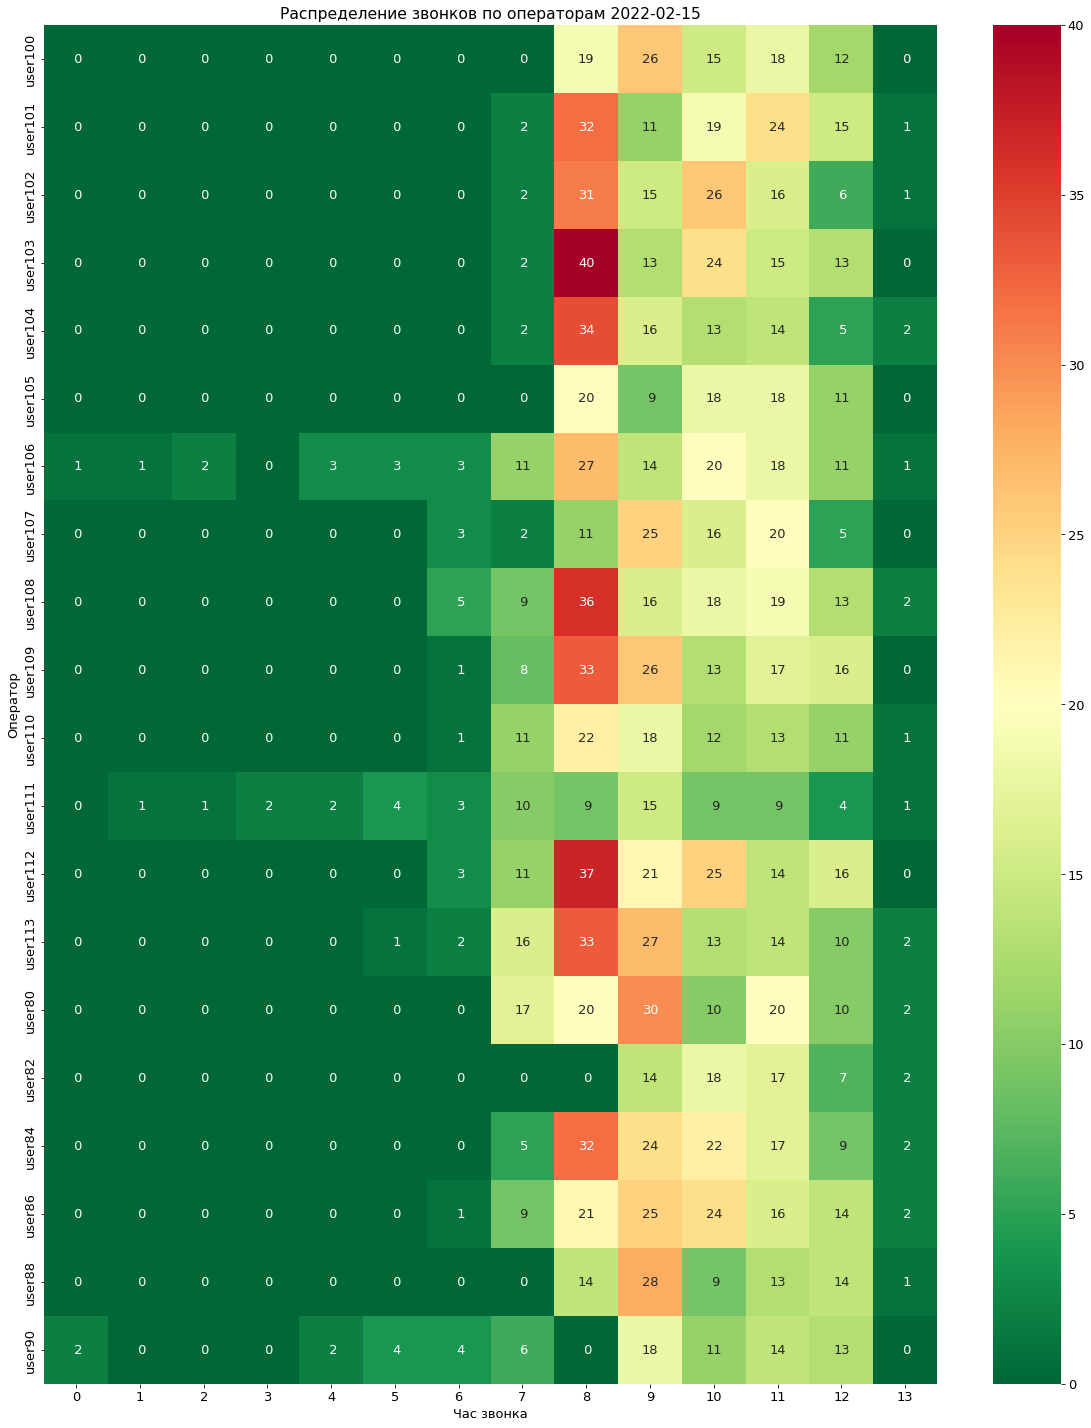

In [566]:
import seaborn as sns
import matplotlib.pyplot as plt

stress_on_oper =  df_specific_day[(df_specific_day['Оператор']!='user8') & (df_specific_day['Оператор']!='user9')& (df_specific_day['Оператор']!='Не определен') & (df_specific_day['Оператор']!='--')]

f = plt.figure(figsize=(20,25))
heatmap_plot = sns.heatmap(pd.crosstab(stress_on_oper['Оператор'], stress_on_oper['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="2")
plt.title('Распределение звонков по операторам '+ str(reporting_date))

plt.show()

### Распределение звонков по операторам на втором домене

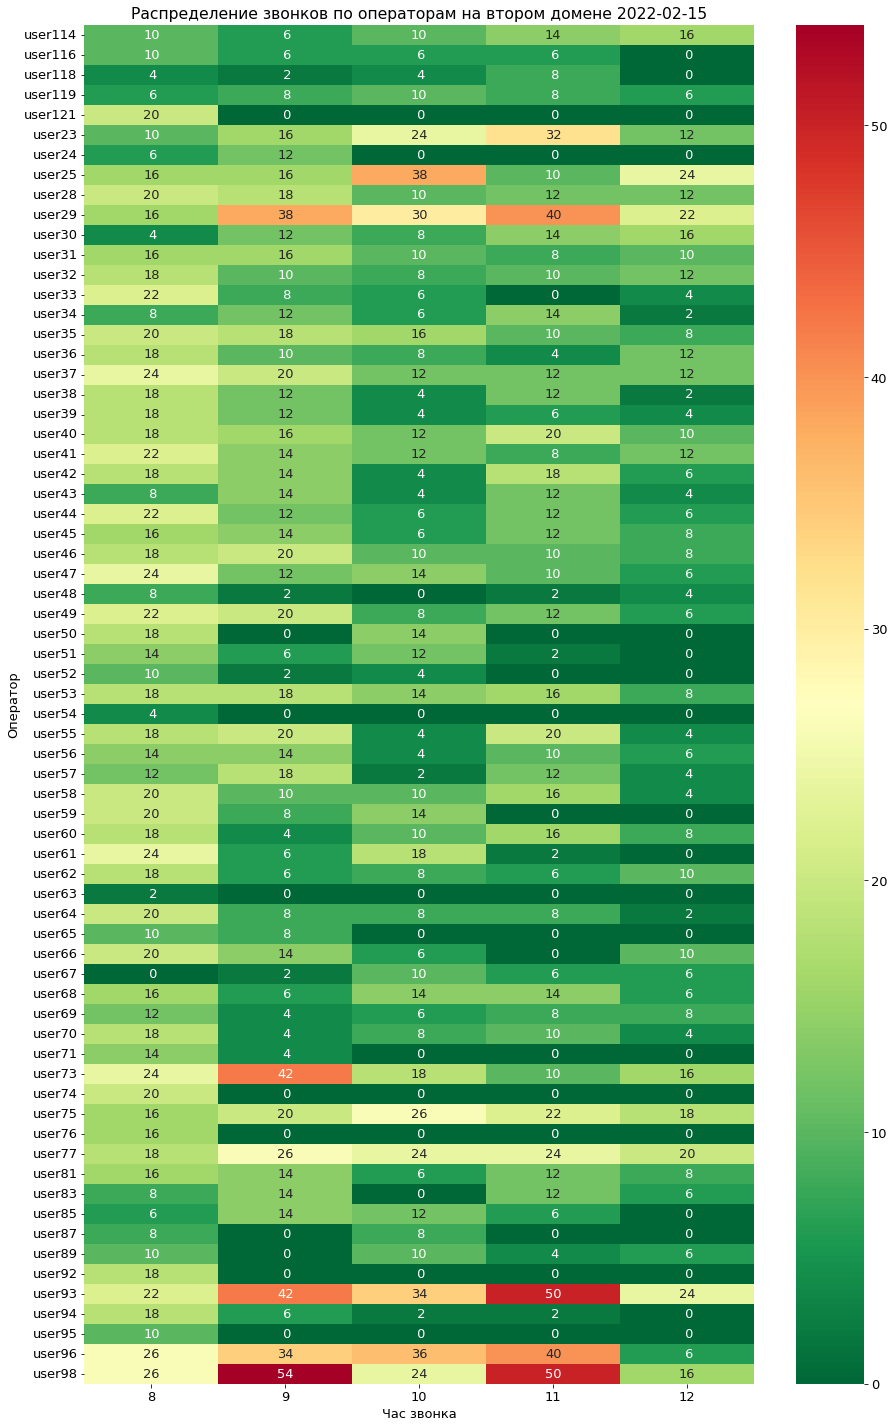

In [567]:
stress_on_oper2 =  df_specific_day2[(df_specific_day2['Оператор']!='user8') & (df_specific_day2['Оператор']!='user9') & (df_specific_day2['Оператор']!='Не определен') & (df_specific_day2['Оператор']!='--')]

f2 = plt.figure(figsize=(15,25))
heatmap_plot2 = sns.heatmap(pd.crosstab(stress_on_oper2['Оператор'], stress_on_oper2['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="2")
plt.title('Распределение звонков по операторам на втором домене '+ str(reporting_date2))

plt.show()

### Обшее количество недозвонов по часам за конкретную дату по первому домену

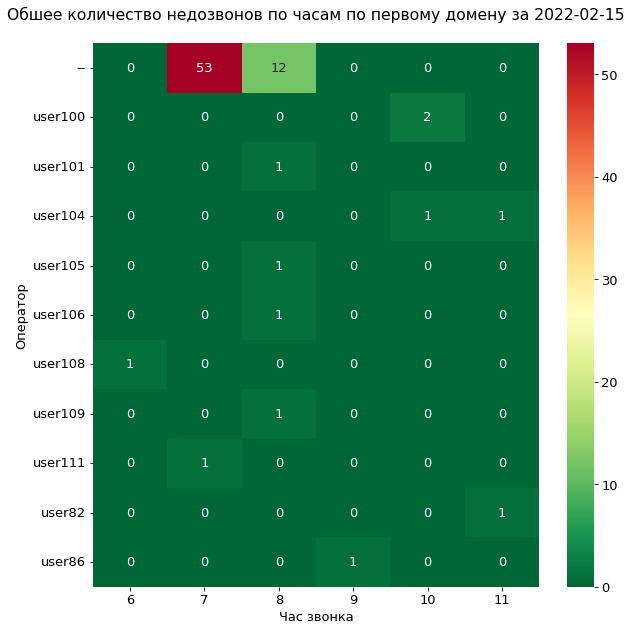

In [568]:
didnot_calls = df_specific_day[(df_specific_day['Оператор'] == '--') | (df_specific_day['Статус звонка'] == 'Не дождался')]

print_didnot_calls = didnot_calls[['Время звонка', 'Номер телефона', 'Время ожидания звонка', 'Оператор']].copy()
print_didnot_calls.to_excel(f"Обшее количество недозвонов по первому домену {reporting_date2}.xlsx")


f = plt.figure(figsize=(10,10))

heatmap_plot = sns.heatmap(pd.crosstab(didnot_calls['Оператор'], didnot_calls['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1")
plt.title('Обшее количество недозвонов по часам по первому домену за '+ str(reporting_date2) + '\n')

plt.show()

### Обшее количество недозвонов по часам за конкретную дату по второму домену

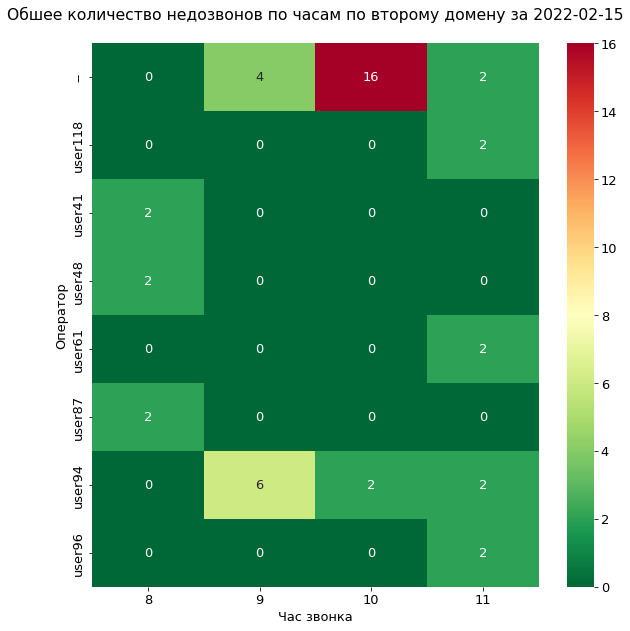

In [569]:
didnot_calls2 = df_specific_day2[(df_specific_day2['Оператор'] == '--') | (df_specific_day2['Статус звонка'] == 'Не дождался')]

print_didnot_calls2 = didnot_calls2[['Время звонка', 'Номер телефона', 'Группа', 'Время ожидания звонка', 'Оператор']].copy()
print_didnot_calls2.to_excel(f"Обшее количество недозвонов по второму домену {reporting_date2}.xlsx")

f = plt.figure(figsize=(10,10))

heatmap_plot = sns.heatmap(pd.crosstab(didnot_calls2['Оператор'], didnot_calls2['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1")
plt.title('Обшее количество недозвонов по часам по второму домену за '+ str(reporting_date2) + '\n')

plt.show()

### Распределение звонков по операторам за конкретную дату по первому домену

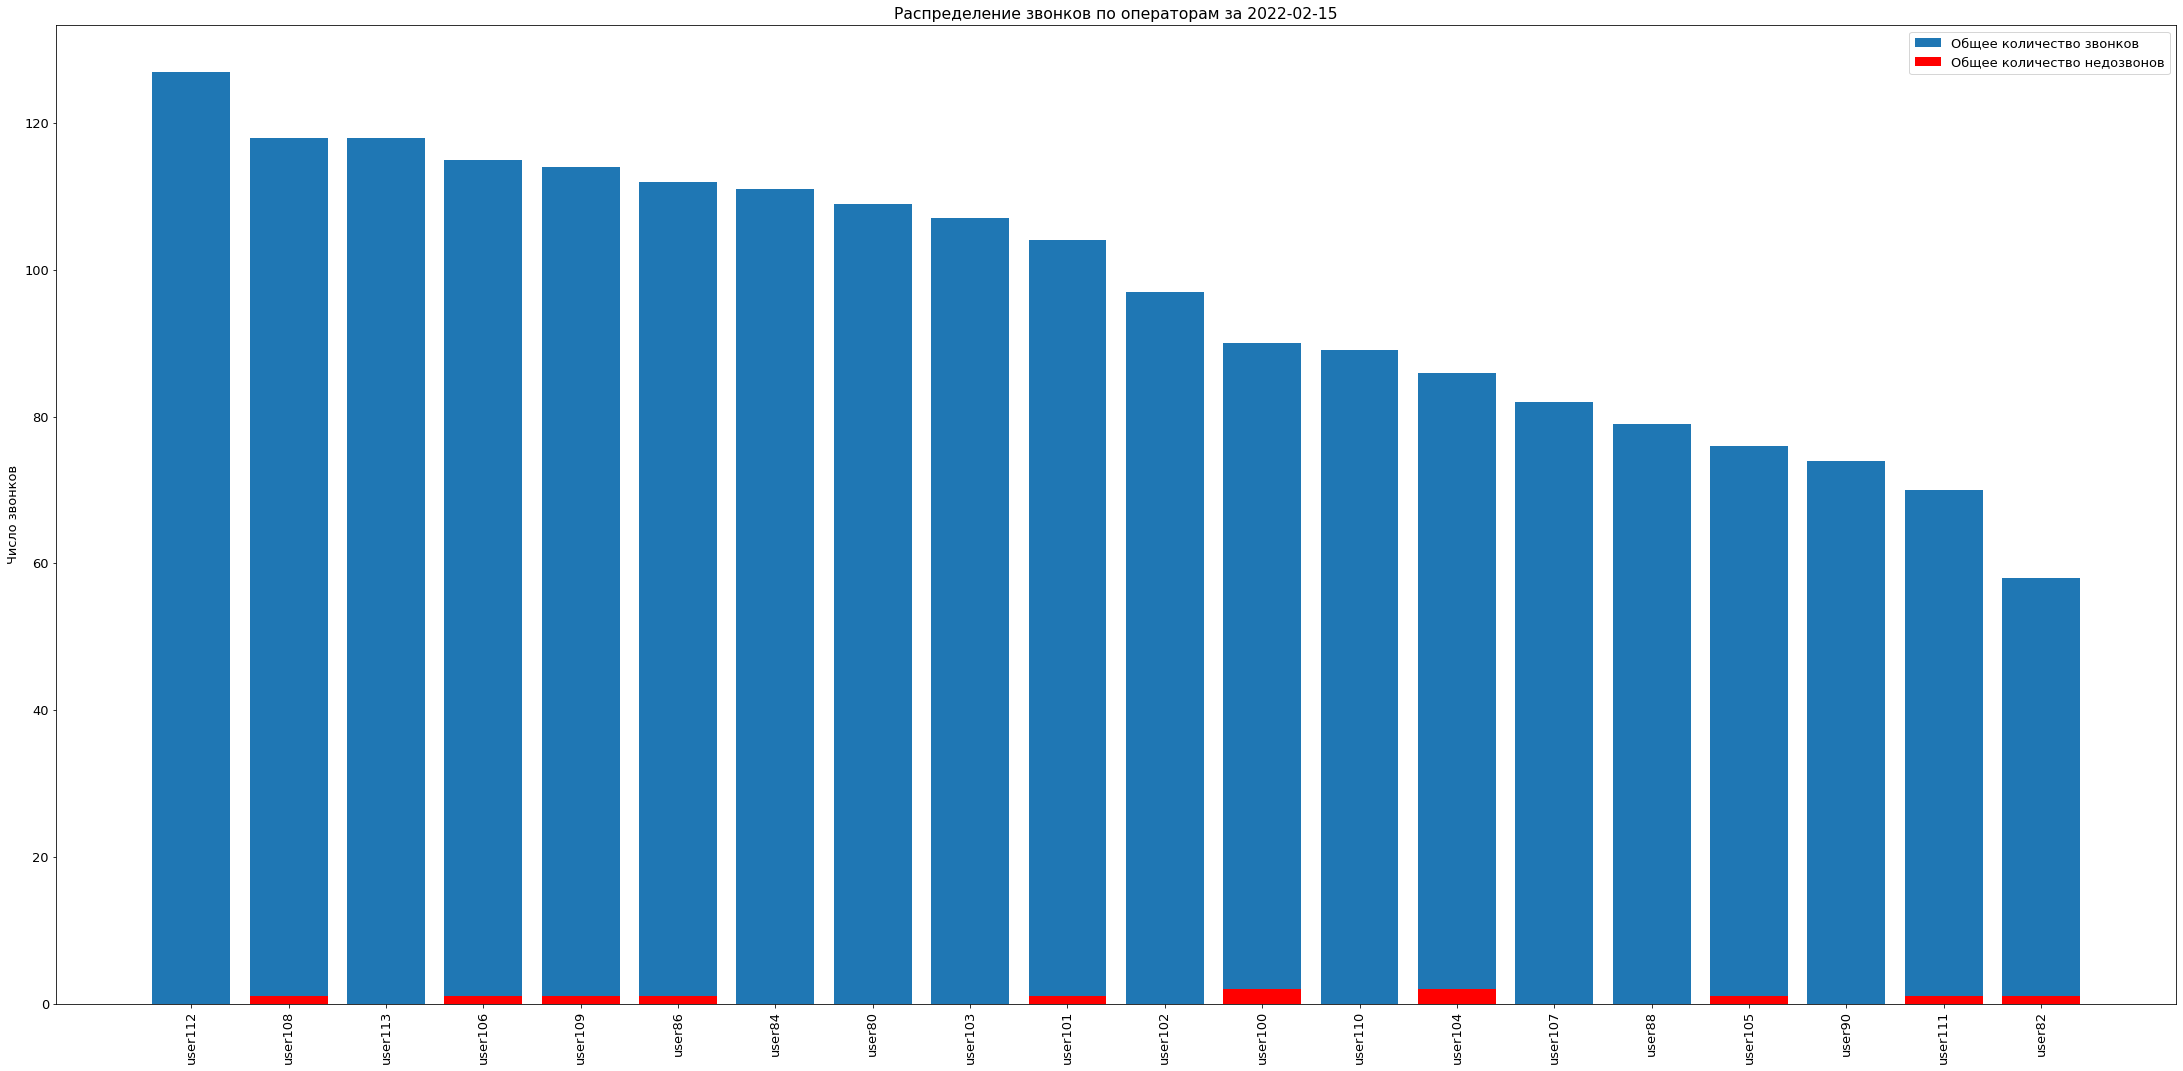

In [570]:
all_calls = stress_on_oper.groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков").sort_values('Число звонков',ascending=False)

didnot_calls_oper = stress_on_oper[stress_on_oper['Статус звонка']=='Не дождался'].groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков")

f = plt.figure(figsize=(38,18))
plt.bar(all_calls['Оператор'], all_calls['Число звонков'],label='Общее количество звонков')
plt.bar(didnot_calls_oper['Оператор'], didnot_calls_oper['Число звонков'],label='Общее количество недозвонов',color='red')

plt.ylabel('Число звонков')
plt.title('Распределение звонков по операторам за '+ str(reporting_date))

plt.rcParams.update({'font.size': 13})
plt.gca().xaxis.set_tick_params(rotation = 90) 
plt.legend()
plt.show()

### Распределение звонков по операторам за конкретную дату по второму домену

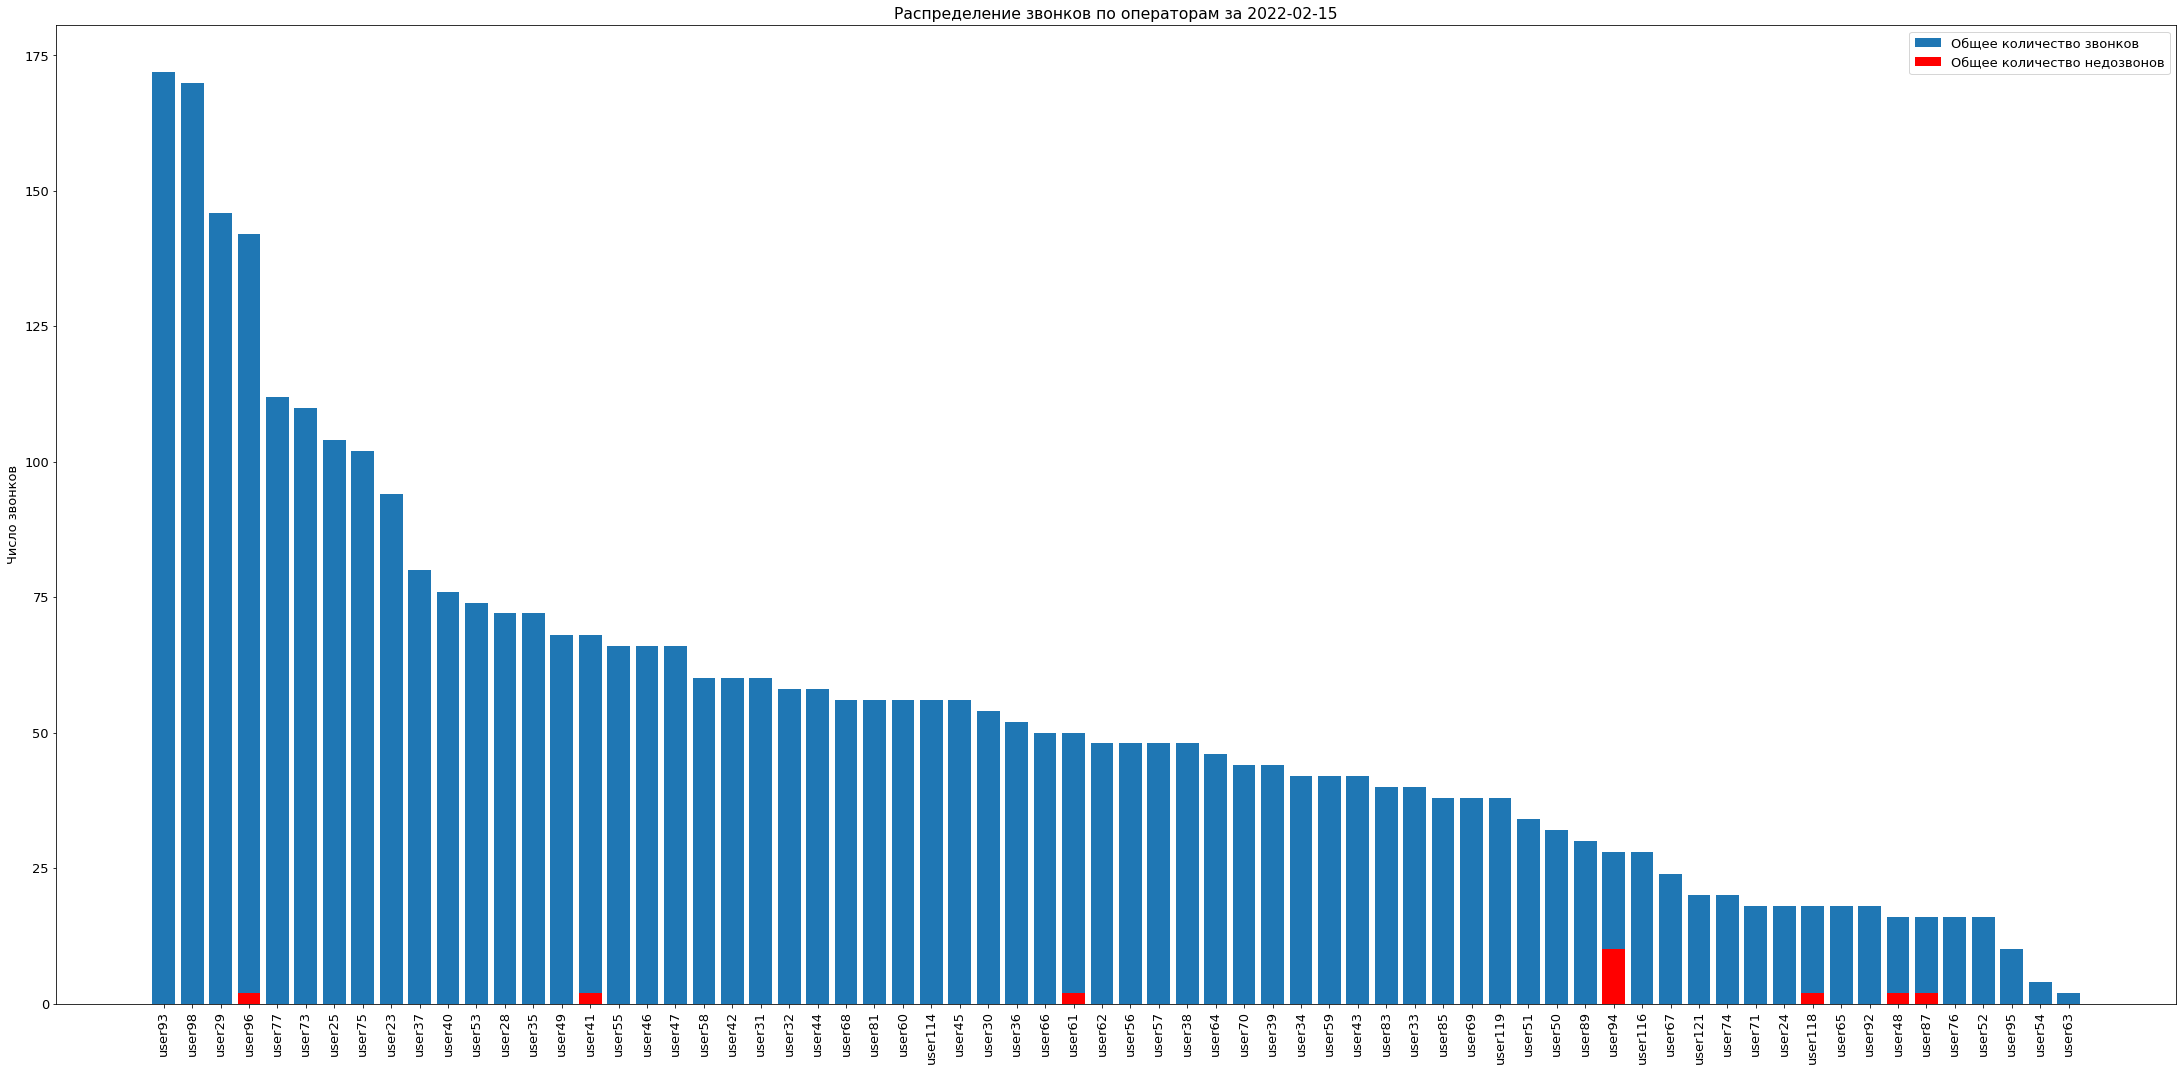

In [571]:
all_calls2 = stress_on_oper2.groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков").sort_values('Число звонков',ascending=False)

didnot_calls2_oper = stress_on_oper2[stress_on_oper2['Статус звонка']=='Не дождался'].groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков")

f = plt.figure(figsize=(38,18))
plt.bar(all_calls2['Оператор'], all_calls2['Число звонков'],label='Общее количество звонков')
plt.bar(didnot_calls2_oper['Оператор'], didnot_calls2_oper['Число звонков'],label='Общее количество недозвонов',color='red')

plt.ylabel('Число звонков')
plt.title('Распределение звонков по операторам за '+ str(reporting_date2))

plt.rcParams.update({'font.size': 13})
plt.gca().xaxis.set_tick_params(rotation = 90) 
plt.legend()
plt.show()

### Общее количество звонков на втором домене в разрезе групп на отчётную дату 

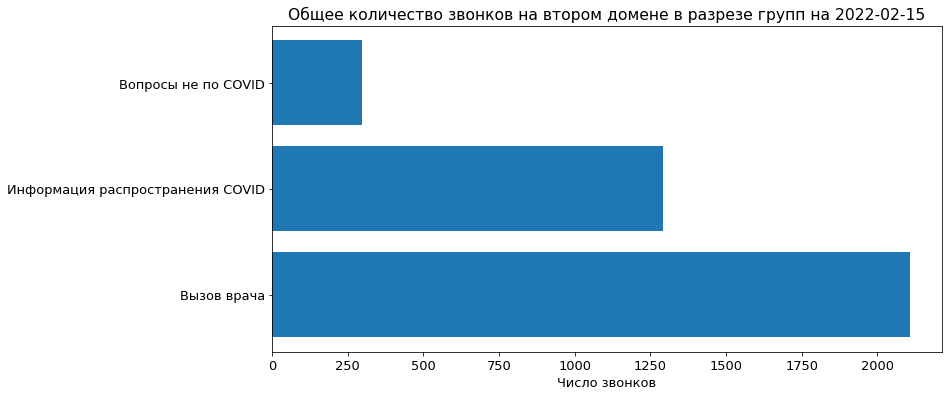

In [572]:
# Общее количество звонков на втором домене в разрезе групп
group_calls2=df_specific_day2.groupby('Группа')['Час звонка'].count().reset_index(name="Число звонков").sort_values(by='Число звонков',ascending=False)


f = plt.figure(figsize=(12,6))
plt.barh(group_calls2['Группа'], group_calls2['Число звонков'],label='Общее количество звонков')

plt.xlabel('Число звонков')
plt.title(f'Общее количество звонков на втором домене в разрезе групп на {reporting_date2}')

plt.rcParams.update({'font.size': 13})
plt.show()

### Общее количество звонков на втором домене в разрезе групп на отчётную дату (Круговая диаграмма)

Общее количество звонков на втором домене в разрезе групп на 2022-02-15


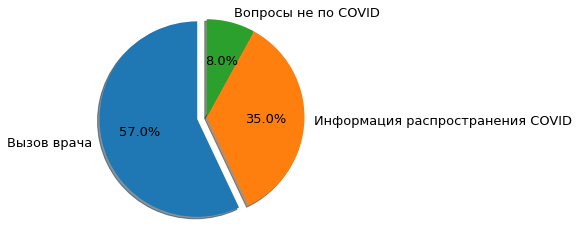

In [595]:
vals = group_calls2['Число звонков']
labels = group_calls2['Группа']
explode = tuple([0.1 if x == 0 else 0 for x in range(len(labels))])

fig, ax = plt.subplots()
ax.pie(vals, labels=labels, explode=explode, autopct='%1.1f%%',shadow=True, startangle=90)
ax.axis("equal")
print(f'Общее количество звонков на втором домене в разрезе групп на {reporting_date2}')

### Динамика звонков по часам за конкретную дату на первом домене


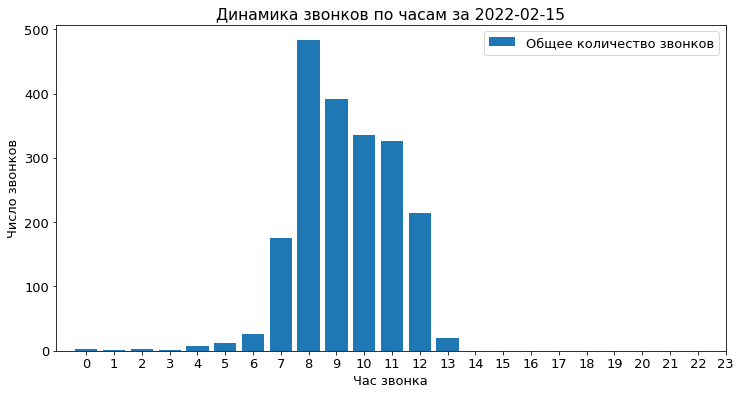

In [533]:
count_calls = df_specific_day.groupby('Час звонка')['Дата звонка'].count().reset_index(name="Число звонков")
f = plt.figure(figsize=(12,6))
plt.bar(count_calls['Час звонка'], count_calls['Число звонков'],label='Общее количество звонков')

plt.xlabel('Час звонка')
plt.ylabel('Число звонков')
plt.title(f'Динамика звонков по часам за {reporting_date}')

plt.rcParams.update({'font.size': 13})
plt.xticks(np.arange(0,24,1))
plt.legend()
plt.show()

### Динамика звонков по часам за конкретную дату на втором домене


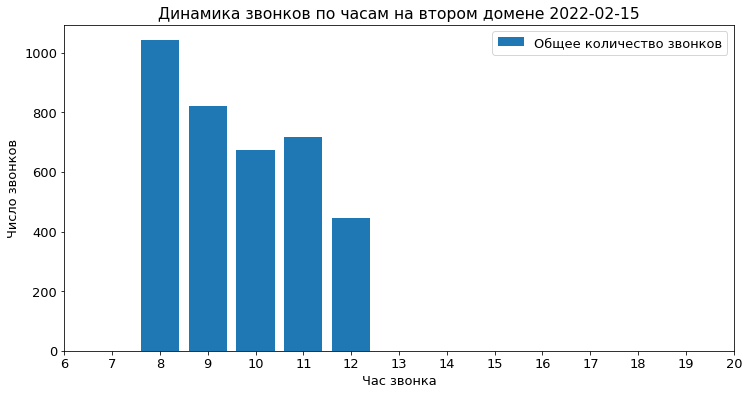

In [534]:
count_calls2 = df_specific_day2.groupby('Час звонка')['Дата звонка'].count().reset_index(name="Число звонков")
f = plt.figure(figsize=(12,6))
plt.bar(count_calls2['Час звонка'], count_calls2['Число звонков'],label='Общее количество звонков')

plt.xlabel('Час звонка')
plt.ylabel('Число звонков')
plt.title(f'Динамика звонков по часам на втором домене {reporting_date2}')

plt.rcParams.update({'font.size': 13})
plt.xticks(np.arange(6,21,1))
plt.legend()
plt.show()

In [535]:
tmp=total_all_days[(total_all_days['Дата звонка']>=dt.date(2021,4,1)) & (total_all_days['Дата звонка']<=dt.date(2021,4,30))].groupby('Дата звонка')['Час звонка'].count().reset_index(name="Число звонков")
tmp2=total_all_days [ (total_all_days['Статус звонка']!='Не дождался') & (total_all_days['Дата звонка']>=dt.date(2021,4,1)) & (total_all_days['Дата звонка']<=dt.date(2021,4,30))].groupby('Дата звонка')['Час звонка'].count().reset_index(name="Число звонков")
Total = tmp2['Число звонков'].sum()

print(tmp2)
print(Total)


   Дата звонка  Число звонков
0   2021-04-01           1021
1   2021-04-02            841
2   2021-04-03            216
3   2021-04-04            126
4   2021-04-05           1555
5   2021-04-06           1061
6   2021-04-07           1153
7   2021-04-08            884
8   2021-04-09            964
9   2021-04-10            154
10  2021-04-11             85
11  2021-04-12           1414
12  2021-04-13            851
13  2021-04-14            581
14  2021-04-15            618
15  2021-04-16            686
16  2021-04-17            105
17  2021-04-18             81
18  2021-04-19           1232
19  2021-04-20            755
20  2021-04-21            725
21  2021-04-22            556
22  2021-04-23            513
23  2021-04-24            131
24  2021-04-25             66
25  2021-04-26           1140
26  2021-04-27            956
27  2021-04-28            475
28  2021-04-29            369
29  2021-04-30            417
19731


# РОСТЕЛЕКОМ первый домен

In [536]:
# namesRT = glob.glob('/home/trinity/Anaconda code/Работа/Недозвоны/Ростелеком/*', recursive=True)
namesRT = glob.glob('../Недозвоны/Ростелеком/*', recursive=True)
contRT=[]
for i in range(len(namesRT)):
    
    date=re.search( r'[0-9]{4}-[0-9]{2}-[0-9]{2}', namesRT[i]).group()
    df_RT = pd.read_excel(namesRT[i],dtype={'Номер вызывающего': str})
    if (dt.datetime.strptime(date, "%Y-%m-%d")<dt.datetime(2021,4,22)):
        df_RT['Длительность']=df_RT['Длительность'].str.replace( ' мин.', '').str.replace(' сек.', '')        
        df_RT['Длительность']=df_RT['Длительность'].apply(lambda x: int(x.split(' ')[0])*60+int(x.split(' ')[1]) if len(x.split(' '))==2 else int(x.split(' ')[0]))
    else:
        df_RT['Длительность']=pd.to_timedelta(df_RT['Длительность'].astype('str'))
        df_RT['Длительность']=df_RT['Длительность'].apply(lambda x: x.total_seconds())
    df_RT=df_RT[df_RT['Длительность'] > 9]
    
    df_RT= df_RT[['Дата вызова','Время вызова','Номер вызывающего','Номер вызываемого', 'Первый ответивший', 'Статус', 'Длительность', 'Группа']]
    df_RT['Номер вызываемого']=df_RT['Номер вызываемого'].astype('str')
    df_RT['Время вызова']=df_RT['Время вызова'].apply(lambda x: dt.datetime.strptime(x, '%H:%M:%S'))
    df_RT['Дата вызова']=pd.to_datetime(df_RT['Дата вызова'])
    df_RT['День недели']=df_RT['Дата вызова'].apply(lambda x: x.weekday())
    df_RT['Час звонка']=df_RT['Время вызова'].dt.hour
    df_RT['Время вызова']=df_RT['Время вызова'].dt.time    
    contRT.append(df_RT)
    
total_all_days_RT = pd.concat(contRT,ignore_index=True)

total_all_days_RT = total_all_days_RT.rename(columns={'Первый ответивший': 'Оператор'})
total_all_days_RT['Группа']=total_all_days_RT['Группа'].replace({'Общая':'Медколледж','Консультация':'Облкомобразования'})
total_all_days_RT['Группа']=total_all_days_RT['Группа'].fillna('Не определена')
total_all_days_RT['Оператор']=total_all_days_RT['Оператор'].replace({' ':'Не определен'})

total_all_days_RT = total_all_days_RT.drop(total_all_days_RT[(total_all_days_RT['Группа'] =='Не определена') & (total_all_days_RT['Статус'] =='пропущенный')].index)
total_all_days_RT = total_all_days_RT.drop(total_all_days_RT[(total_all_days_RT['Длительность'] < 120) & (total_all_days_RT['Статус'] =='пропущенный')].index)

total_all_days_RT['Номер вызывающего']=total_all_days_RT['Номер вызывающего'].str.replace(' ', '')
total_all_days_RT['Номер вызываемого']=total_all_days_RT['Номер вызываемого'].str.replace(' ', '')
hospitals=pd.read_excel('Переадресация телефонов.xlsx')
total_all_days_RT=total_all_days_RT.merge(hospitals, how = 'left', left_on='Номер вызывающего', right_on='Единый номер')

total_all_days_RT['Наименование учреждения'] = total_all_days_RT['Наименование учреждения'].str.replace('Государственное учреждение здравоохранения','ГУЗ')
total_all_days_RT['Наименование учреждения'] = total_all_days_RT['Наименование учреждения'].str.replace('Государственное бюджетное учреждение здравоохранения','ГБУЗ') 
total_all_days_RT['Наименование учреждения'] = total_all_days_RT['Наименование учреждения'].str.replace('Клиническая больница скорой медицинской помощи','КБСМП')
total_all_days_RT['Наименование учреждения'] = total_all_days_RT['Наименование учреждения'].str.replace('клиническая поликлиника','КП')

C:\Users\Admin\AppData\Local\Temp/ipykernel_12528/3376279938.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_RT['Длительность']=df_RT['Длительность'].str.replace( ' мин.', '').str.replace(' сек.', '')


In [537]:
# Определение зон

def give_missed_calls_zone(percentage):
    zone = ''
    if (percentage >= 15):
        zone = 'красная'
    elif ( 5 < percentage < 15):
        zone = 'желтая'
    else:
        zone = 'зеленая'
    return zone


def give_mean_wait_zone(time_wait):
    zone = ''
    if (time_wait > 10):
        zone = 'красная'
    elif ( 2 < time_wait <= 10):
        zone = 'желтая'
    else:
        zone = 'зеленая'
    return zone

# Cчитаем отчёт для ЕА
def report_for_EA(df_VMK, df_RT):
    # дата отчёта
    report_data = df_VMK['Дата звонка'].values[0].strftime("%d.%m.%Y")
    # всего звонков
    all_calls = df_RT[df_RT['Номер вызываемого']=='78442325552'].shape[0]
    # количество неотвеченных
    missed_calls_count = df_RT[(df_RT['Статус']=='пропущенный') & (df_RT['Номер вызываемого']=='78442325552')].shape[0]   
    # Рассчитываем процент недозвонов    
    percentage_missed = np.round(missed_calls_count/all_calls * 100, 2)
    missed_calls_zone = give_missed_calls_zone(percentage_missed)
    # Рассчитываем среднее время ожидания
    mean_wait = np.round(df_VMK['Время ожидания'].mean(),3)
    mean_wait_zone = give_mean_wait_zone(mean_wait)
        
    print(f"""Информация по вызовам на "122" за {report_data}:
Всего вызовов: {all_calls}
Неотвеченных вызовов: {missed_calls_count} ( {str(percentage_missed).replace('.',',')}%, {missed_calls_zone} зона)
Среднее время ожидания: {str(mean_wait).replace('.',',')} мин. ({mean_wait_zone} зона)
""")

##### 

In [539]:
def calculate_statistics_RT(dataframe):
    all_calls_count=dataframe.shape[0]
    all_calls_5552_count=dataframe[dataframe['Номер вызываемого']=='78442325552'].shape[0]
    all_calls_5554_count=dataframe[dataframe['Номер вызываемого']=='78442325554'].shape[0]
    missed_calls=dataframe[dataframe['Статус']=='пропущенный']
    missed_calls_count=missed_calls.shape[0]
    missed_calls_5552_count=missed_calls[missed_calls['Номер вызываемого']=='78442325552'].shape[0]
    missed_calls_5554_count=missed_calls[missed_calls['Номер вызываемого']=='78442325554'].shape[0]
    
    hospital_calls=dataframe[dataframe['Наименование учреждения'].isnull()==False]
    hospital_calls_count=hospital_calls.shape[0]
    hospital_calls_count_5552=hospital_calls[hospital_calls['Номер вызываемого']=='78442325552'].shape[0]
    hospital_calls_count_5554=hospital_calls[hospital_calls['Номер вызываемого']=='78442325554'].shape[0]
    
    print('По выгрузке Ростелекома: неотвеченных вызовов - {0} %'.format(np.round(missed_calls_5552_count/all_calls_5552_count*100,2)))
    print('Всего вызовов – {0}, неотвеченных – {1} (отфильтровано менее 120 сек, а также по группе "Не определена").'.format(all_calls_5552_count, missed_calls_5552_count))
      
    


In [540]:
from datetime import datetime
def calculate_statistics_WMK(dataframe):      
    # Рассчитываем максимальнок время ожидание
    max_wait_df = dataframe[dataframe['Время ожидания']==dataframe['Время ожидания'].max()]
    group_with_max_wait = max_wait_df['Группа'].values[0]
    oper__with_max_wait = max_wait_df['Оператор'].values[0]    
    max_wait=np.round(dataframe['Время ожидания'].max(),1)
    time_with_max_wait = max_wait_df['Время звонка'].values[0]    
    report_data = dataframe['Дата звонка'].values[0].strftime("%d.%m.%Y")
    report_data_time = datetime.now().strftime("%H:%M")
    
    print(f"""
Информация по вызовам по состоянию на {report_data_time} за {report_data}.
Максимальное время ожидания за сутки (мин): {max_wait} (Оператор: {oper__with_max_wait}, Группа: {group_with_max_wait}, Время звонка: {time_with_max_wait}))
    """)
    


# Выбор отчётной даты

In [541]:
dayRT=dt.datetime(2022,2,15)

# Создаём датафрейм для первого домена Ростелеком за определенную дату
df_specific_day_RT = total_all_days_RT[total_all_days_RT['Дата вызова'] == dayRT]

### Считаем статистику по первому домену

In [542]:
calculate_statistics_WMK(df_specific_day)
calculate_statistics_RT(df_specific_day_RT)
#total_all_days_RT[(total_all_days_RT['Номер вызываемого']=='78442325552') & (total_all_days_RT['Дата вызова']==dayRT) & (total_all_days_RT['Статус']=='пропущенный')]

table_RT=total_all_days_RT[(total_all_days_RT['Номер вызываемого']=='78442325552') & (total_all_days_RT['Дата вызова']==dayRT) & (total_all_days_RT['Статус']=='пропущенный')]
table_RT.to_excel("Неотвеченные.xlsx")


Информация по вызовам по состоянию на 14:33 за 15.02.2022.
Максимальное время ожидания за сутки (мин): 10.2 (Оператор: user80, Группа: Медколледж, Время звонка: 07:49:38))
    
По выгрузке Ростелекома: неотвеченных вызовов - 0.55 %
Всего вызовов – 2001, неотвеченных – 11 (отфильтровано менее 120 сек, а также по группе "Не определена").


### Распределение звонков по операторам

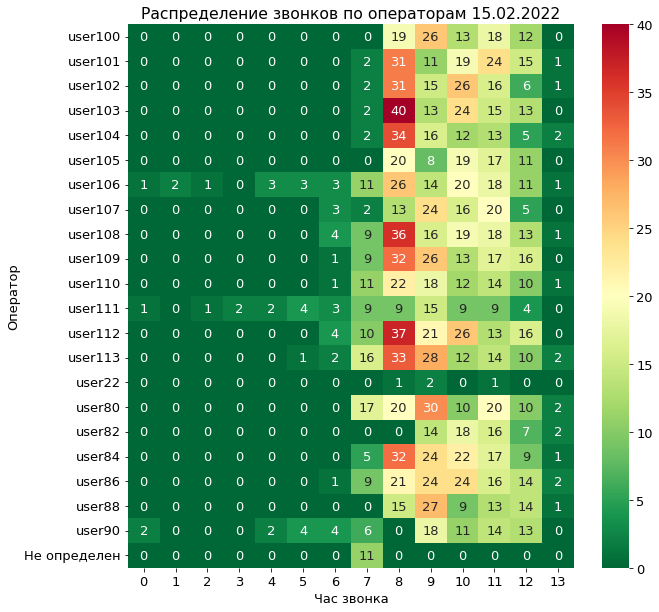

In [543]:
################################################################################################
tmp = df_specific_day_RT[(df_specific_day_RT['Номер вызываемого'] =='78442325552') & (df_specific_day_RT['Оператор']!='user8') & (df_specific_day_RT['Оператор']!='user9')]

f = plt.figure(figsize=(10,10))
heatmap_plot = sns.heatmap(pd.crosstab(tmp['Оператор'], tmp['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1")
plt.title('Распределение звонков по операторам '+day.strftime('%d.%m.%Y'))

plt.show()


### Обшее количество недозвонов по часам

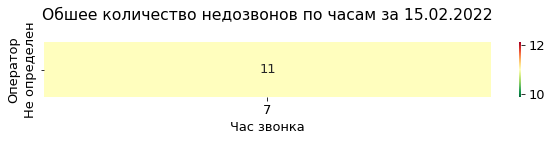

In [544]:
temp2 = tmp[tmp['Оператор']=='Не определен']
f = plt.figure(figsize=(10,1))
heatmap_plot = sns.heatmap(pd.crosstab(temp2['Оператор'], temp2['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1")
plt.title('Обшее количество недозвонов по часам за '+day.strftime('%d.%m.%Y' + '\n'))

plt.show('Не определен')

### Общее количество звонков на первом домене в разрезе групп

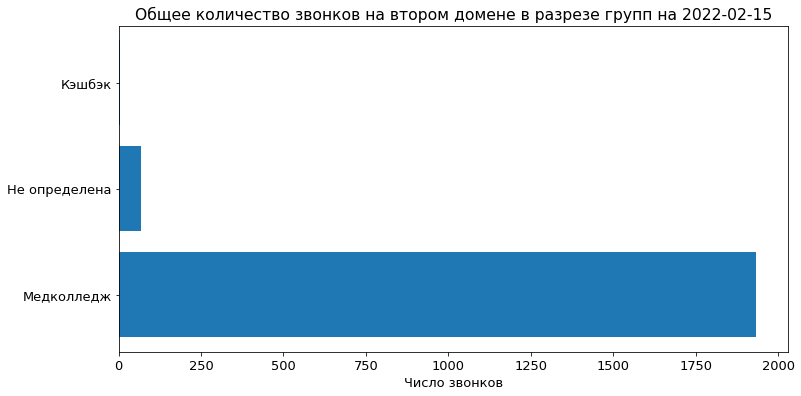

In [545]:
group_calls_RT=df_specific_day_RT.groupby('Группа')['Час звонка'].count().reset_index(name="Число звонков").sort_values(by='Число звонков',ascending=False)


f = plt.figure(figsize=(12,6))
plt.barh(group_calls_RT['Группа'], group_calls_RT['Число звонков'],label='Общее количество звонков')

plt.xlabel('Число звонков')
plt.title(f'Общее количество звонков на втором домене в разрезе групп на {dayRT.date()}')

plt.rcParams.update({'font.size': 13})
plt.show()

### Общее количество звонков на первом домене в разрезе групп (Круговая диаграмма)

Общее количество звонков на первом домене в разрезе групп на 2022-02-15


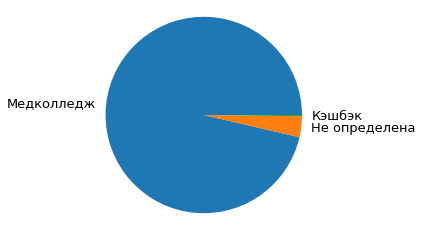

In [600]:
vals = group_calls_RT['Число звонков']
labels = group_calls_RT['Группа']

fig, ax = plt.subplots()
ax.pie(vals, labels=labels)
ax.axis("equal")
print(f'Общее количество звонков на первом домене в разрезе групп на {dayRT.date()}')

In [ ]:
vals = group_calls2['Число звонков']
labels = group_calls2['Группа']
explode = tuple([0.1 if x == 0 else 0 for x in range(len(labels))])

fig, ax = plt.subplots()
ax.pie(vals, labels=labels, explode=explode, autopct='%1.1f%%',shadow=True, startangle=90)
ax.axis("equal")
print(f'Общее количество звонков на втором домене в разрезе групп на {reporting_date2}')

### Выгрузка по успешным звонкам за период

In [547]:
start_RT = '2022-02-04'
end_RT = '2022-02-13'
tmp_RT=total_all_days_RT[(total_all_days_RT['Статус']=='успешный') & (total_all_days_RT['Дата вызова']>=pd.to_datetime(start_RT)) & (total_all_days_RT['Дата вызова']<=pd.to_datetime(end_RT))].groupby('Дата вызова')['Время вызова'].count().reset_index(name="Число звонков")
Total = tmp_RT['Число звонков'].sum()
tmp_RT.to_excel("Успешные звонки.xlsx")
print(f'Всего звонков: {Total}')
tmp_RT

Всего звонков: 32118


,Дата вызова,Число звонков
0,2022-02-04,4761
1,2022-02-05,2794
2,2022-02-06,2846
3,2022-02-07,757
4,2022-02-08,4948
5,2022-02-09,4296
6,2022-02-10,3988
7,2022-02-11,3820
8,2022-02-12,1952
9,2022-02-13,1956


## Отчёт для ЕА


In [548]:
report_for_EA(df_specific_day, df_specific_day_RT)

Информация по вызовам на "122" за 15.02.2022:
Всего вызовов: 2001
Неотвеченных вызовов: 11 ( 0,55%, зеленая зона)
Среднее время ожидания: 0,318 мин. (зеленая зона)

